In [ ]:
# https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html


### 1. Setup and Imports

The core modules required for Data Augmentation in Keras are `ImageDataGenerator` for defining transformations and `image` for loading and processing images.



In [7]:
# Import the necessary modules from Keras or TensorFlow Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt # Used in the source for displaying images, not directly for augmentation
import numpy as np # Used for array manipulations

# (Optional) For displaying images
# import matplotlib.pyplot as plt

### 2. Augmenting a Single Image

This part demonstrates how to apply transformations to a single image and save the augmented versions.

#### 2.1. Loading a Single Image

An image is loaded using `image.load_img`, specifying its path and target size. The loaded image is a **PIL (Python Imaging Library) object**, not a NumPy array.


In [4]:
# Path to your image (e.g., a cat image)
# Make sure you have a folder named 'train' and an image 'cat.10.jpg' inside it, or adjust the path
# img_path = 'train/cat.10.jpg' # Example path, adjust as per your setup
img_path='/content/drive/MyDrive/0.self_course_content_data_science/11.3 CNN and Transfer learning/train/Cat.jpg'
target_size = (200, 200) # Desired size for the image

In [10]:
from tensorflow.keras.preprocessing import image

# Load the image
img = image.load_img(img_path, target_size=target_size)
print(f"Type of loaded image: {type(img)}") # Output: <class 'PIL.Image.Image'>

Type of loaded image: <class 'PIL.Image.Image'>


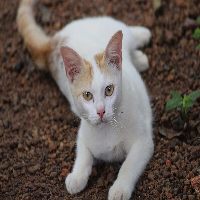

In [12]:
img

In [13]:
type(img)

PIL.Image.Image

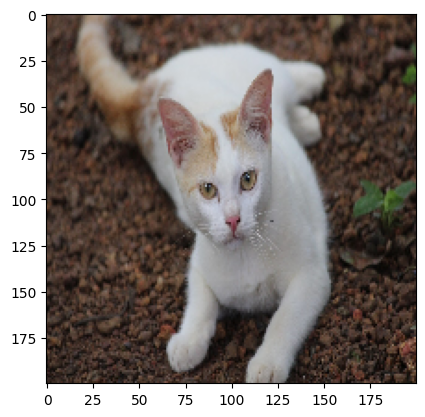

In [11]:

# (Optional) Display the loaded image
plt.imshow(img)
# plt.axis('off')
# plt.title('Original Image')
# plt.show()

#### 2.2. Creating the `ImageDataGenerator` Object

An `ImageDataGenerator` object is instantiated to define the range of transformations to be applied.


In [14]:
# Create an ImageDataGenerator object with desired transformations
data_gen = ImageDataGenerator(
    rotation_range=40,            # Rotate images by 40 degrees
    shear_range=0.2,              # Apply shear transformation
    zoom_range=0.2,               # Randomly zoom images by 20%
    horizontal_flip=True,         # Randomly flip images horizontally
    vertical_flip=False,          # Do not flip vertically (e.g., cats don't appear upside down realistically)
    width_shift_range=0.2,        # Shift images horizontally by 20% of width
    height_shift_range=0.2,       # Shift images vertically by 20% of height
    # fill_mode='nearest'         # Default fill_mode, explained in section 2.6
    # Other parameters like brightness_range can also be added
)
print("ImageDataGenerator object created.")

ImageDataGenerator object created.


#### 2.3. Preparing the Image for Generation

The PIL image needs to be converted into a NumPy array and then reshaped to include a batch dimension, as `flow()` expects batch input.


In [16]:
# Convert the PIL image to a NumPy array
img_array = img_to_array(img)
print(f"Type after img_to_array: {type(img_array)}") # Output: <class 'numpy.ndarray'>
print(f"Shape after img_to_array: {img_array.shape}") # Output: (200, 200, 3)


Type after img_to_array: <class 'numpy.ndarray'>
Shape after img_to_array: (200, 200, 3)


In [17]:
type(img_array)

numpy.ndarray

In [20]:
img_array.shape

(200, 200, 3)

In [21]:

# Reshape the image to add a batch dimension (1 for a single image)
# The flow() function expects input in the shape (batch_size, height, width, channels)
# input_batch = img_array.reshape((1,200,200,3)
input_batch = img_array.reshape((1,) + img_array.shape)
print(f"Shape after reshaping for batch: {input_batch.shape}") # Output: (1, 200, 200, 3)

Shape after reshaping for batch: (1, 200, 200, 3)


#### 2.4. Generating Images from a Single Image

The `flow()` method is used to generate augmented images. It creates an infinite loop, so a manual break condition is needed to generate a specific number of images. The generated images are saved to a specified directory.



In [22]:

# Create a directory to save augmented images if it doesn't exist
import os
output_dir = 'ug' # As named in the source
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    print(f"Directory '{output_dir}' created.")

# Use flow() to generate augmented images
# The loop generates 10 augmented images (0 to 9)
i = 0
for batch in data_gen.flow(input_batch, batch_size=1,
                           save_to_dir=output_dir,
                           save_prefix='aug',
                           save_format='jpeg'):
    i += 1
    if i >= 10: # Generate 10 images
        break
print(f"Generated {i} augmented images in the '{output_dir}' directory.")

Directory 'ug' created.
Generated 10 augmented images in the 'ug' directory.


#### 2.5. Understanding the `fill_mode` Parameter

When transformations like shifting or rotation create empty spaces at the image boundaries, `fill_mode` specifies how these new pixels are filled.


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Example of fill_mode='nearest' (default)
data_gen_nearest = ImageDataGenerator(
    rotation_range=40, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2,
    fill_mode='nearest'
)
# (Code to generate images would be similar to 2.4, just using data_gen_nearest)

# Example of fill_mode='reflect'
data_gen_reflect = ImageDataGenerator(
    rotation_range=40, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2,
    fill_mode='reflect' # Reflects pixels from the boundaries
)
# (Code to generate images would be similar to 2.4, just using data_gen_reflect)

# Example of fill_mode='constant'
data_gen_constant = ImageDataGenerator(
    rotation_range=40, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2,
    fill_mode='constant', # Fills with a constant value (e.g., black by default)
    cval=0 # Specify the constant value (0 for black)
)
# (Code to generate images would be similar to 2.4, just using data_gen_constant)
print("Different `fill_mode` options can be set in ImageDataGenerator.")

Different `fill_mode` options can be set in ImageDataGenerator.


### 3. Applying Data Augmentation to an Entire Directory for Classification

This section shows how to apply Data Augmentation to a training dataset organised in directories, as typically done for image classification projects.

#### 3.1. `ImageDataGenerator` Setup for Training and Validation

Different generators are used for training and validation. **Crucially, augmentation transformations (shear, zoom, flip) are only applied to the training data.** The validation data only undergoes `rescale` to normalise pixel values, ensuring it represents real-world, un-augmented samples for evaluation.


In [ ]:
# Define paths to your training and validation data
# Assuming your data is structured like: data/train/cats/, data/train/dogs/, etc.
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# ImageDataGenerator for Training Data (with augmentations)
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalize pixel values
    shear_range=0.2,              # Apply shear transformations
    zoom_range=0.2,               # Apply zoom transformations
    horizontal_flip=True          # Randomly flip images horizontally
    # Other augmentations like rotation, width/height shifts can be added here
)

# ImageDataGenerator for Test/Validation Data (only rescaling, no augmentations)
# Test data should not be augmented, as it needs to represent real-world examples
test_datagen = ImageDataGenerator(rescale=1./255) # Only normalize pixel values

print("ImageDataGenerator objects created for training and validation.")


#### 3.2. Loading Data from Directories using `flow_from_directory`

The `flow_from_directory()` method is used to efficiently load images from class-specific subfolders.


In [ ]:
# Training data generator
train_generator = train_datagen.flow_from_directory(
    train_data_dir,               # Path to the training data directory
    target_size=(150, 150),       # All images will be resized to 150x150
    batch_size=16,                # Number of images per batch
    class_mode='binary'           # For binary classification (cats vs. dogs)
)

# Validation data generator
validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,          # Path to the validation data directory
    target_size=(150, 150),       # All images will be resized to 150x150
    batch_size=16,                # Number of images per batch
    class_mode='binary'           # For binary classification
)

# Output from flow_from_directory will confirm the number of images found
# Example: "Found 1000 images belonging to 2 classes."

#### 3.3. Model Architecture (Conceptual)

The source indicates the use of the **same model architecture** for both non-augmented and augmented training. It consists of convolutional and max-pooling layers, followed by flatten, dense, and a dropout layer. The final layer uses a Sigmoid activation for binary classification, compiled with `RMSprop` and `binary_crossentropy`.



In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# This model architecture is copied from the source's description
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5), # Dropout layer for regularization
    Dense(1, activation='sigmoid') # Output layer for binary classification
])

# Compile the model
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
print("Model architecture defined and compiled.")



#### 3.4. Model Training with `fit_generator`

When using `ImageDataGenerator` for training, `model.fit()` is replaced with `model.fit_generator()`. This method takes the `train_generator` and `validation_data` generators as input, which continuously produce batches of augmented images during training.


In [ ]:
# Train the model using fit_generator
# steps_per_epoch is typically total_training_samples / batch_size
# validation_steps is typically total_validation_samples / batch_size
epochs = 25 # The source shows training for 25 epochs to achieve 74% accuracy

# Assuming 1000 training images and 1000 validation images, batch_size=16
steps_per_epoch = 1000 // 16
validation_steps = 1000 // 16

history = model.fit_generator(
    train_generator,              # Generator providing augmented training data
    steps_per_epoch=steps_per_epoch, # Number of batches to draw from the generator per epoch
    epochs=epochs,                # Number of epochs to train
    validation_data=validation_generator, # Generator providing validation data
    validation_steps=validation_steps     # Number of batches to draw from validation generator
)
print("Model training completed with Data Augmentation.")

# (Optional) Evaluate the model or plot training history
# loss, accuracy = model.evaluate_generator(validation_generator, steps=validation_steps)
# print(f"Validation Accuracy: {accuracy*100:.2f}%")


In [ ]:
# The source highlights that with Data Augmentation, the model achieved **69% validation accuracy after 5 epochs** compared to 57% without augmentation, and reached **74% after 25 epochs**, demonstrating a significant improvement in performance on a limited dataset.